### Импорт пакетов

In [5]:
import requests
import json

import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch, FontManager
from matplotlib import rcParams

import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

### Получаем данные из CSV

In [6]:
df_events = pd.read_csv('all_data.csv', index_col=0)
df_events.columns

Index(['id', 'matchId', 'matchPeriod', 'minute', 'second', 'matchTimestamp',
       'videoTimestamp', 'relatedEventId', 'shot', 'groundDuel', 'aerialDuel',
       'infraction', 'carry', 'type_primary', 'type_secondary', 'location_x',
       'location_y', 'team_id', 'team_name', 'team_formation',
       'opponentTeam_id', 'opponentTeam_name', 'opponentTeam_formation',
       'player_id', 'player_name', 'player_position', 'pass_accurate',
       'pass_angle', 'pass_height', 'pass_length', 'pass_recipient_id',
       'pass_recipient_name', 'pass_recipient_position', 'pass_endLocation_x',
       'pass_endLocation_y', 'possession_id', 'possession_duration',
       'possession_types', 'possession_eventsNumber', 'possession_eventIndex',
       'possession_startLocation_x', 'possession_startLocation_y',
       'possession_endLocation_x', 'possession_endLocation_y',
       'possession_team_id', 'possession_team_name',
       'possession_team_formation', 'possession_attack', 'pass',
       'aeri

### Фильтруем пасы

In [7]:
def progressive_passes_for_team(df_events, team):
    mask_team = (df_events['type_primary'] == 'pass') & \
                (df_events['type_secondary'].str.contains('progressive_pass', regex=False)) & \
                (df_events['pass_accurate'] == True) & \
                (df_events['team_name'] == team)
    df_clear_data = df_events.loc[
        mask_team, 
        ['id', 'matchId', 
         'location_x', 'location_y', 'team_id', 'team_name', 
         'pass_endLocation_x', 'pass_endLocation_y', 'pass_length', 'pass_angle']
    ]
    df_clear_data.rename(columns={'location_x': 'x', 'location_y': 'y', 'pass_endLocation_x': 'endX', 'pass_endLocation_y': 'endY'}, inplace=True)
    return df_clear_data

## Кластерный анализ

### Нормализация и кластеризация

Приводим данные, которые участвуют в кластеризации к диапазону [0..1]  
Добавляем колонку cluster в dataframe

In [8]:
def cluster_passes(df_clear_data):
    # Normalizing
    features = df_clear_data[['x', 'y', 'endX', 'endY', 'pass_length', 'pass_angle']]
    scaler = StandardScaler()
    df_clear_data[['x_norm', 'y_norm', 'endX_norm', 'endY_norm', 'pass_length_norm', 'pass_angle_norm']] = scaler.fit_transform(features)
    
    # Clustering
#     num_of_clusters = int(df_clear_data.x.count() / 5)
    num_of_clusters = 50
    model = KMeans(n_clusters=num_of_clusters, random_state = 100)
    data = df_clear_data[['x_norm', 'y_norm', 'endX_norm', 'endY_norm', 'pass_length_norm', 'pass_angle_norm']]
    model.fit(data)
    
    df_clear_data['cluster'] = model.labels_
    
    return df_clear_data

## Рисуем поле и визуализируем кластеры передач

### Функция, которая рисует пасы одного кластера

In [9]:
def draw_progressive_passes_for_cluster(df_passes, cluster, color, popular_clusters, pitch, ax):
    df_cluster_passes = df_passes[df_passes['cluster'] == cluster]
    highlight = cluster in popular_clusters
    # All passes from cluster
    pitch.arrows(
        df_cluster_passes['x'], df_cluster_passes['y'],
        df_cluster_passes['endX'], df_cluster_passes['endY'], 
        width=1, headwidth=4, headlength=4, color=color, ax=ax
    )
    # Set the title of the pitch as the number of the cluster
    ax.set_title(f'{cluster}', color='white', fontsize=20)

### Функция, которая рисует средние передачи в кластере

In [10]:
def draw_avg_pass_for_clusters(df_passes, colors, pitch, ax):
    for x in range(len(df_passes.cluster)):
        color = colors[x % 16]
        df_cluster_passes = df_passes[df_passes.cluster == x]
        pitch.arrows(
            df_cluster_passes.x.mean(), df_cluster_passes.y.mean(),
            df_cluster_passes.endX.mean(), df_cluster_passes.endY.mean(), 
            width=2, headwidth=5, headlength=5, color=color, ax=ax)


### Рисуем grid со всеми кластерами

Text(0, 0.3, 'РПЛ. Передачи с продвижением.\nSochi')

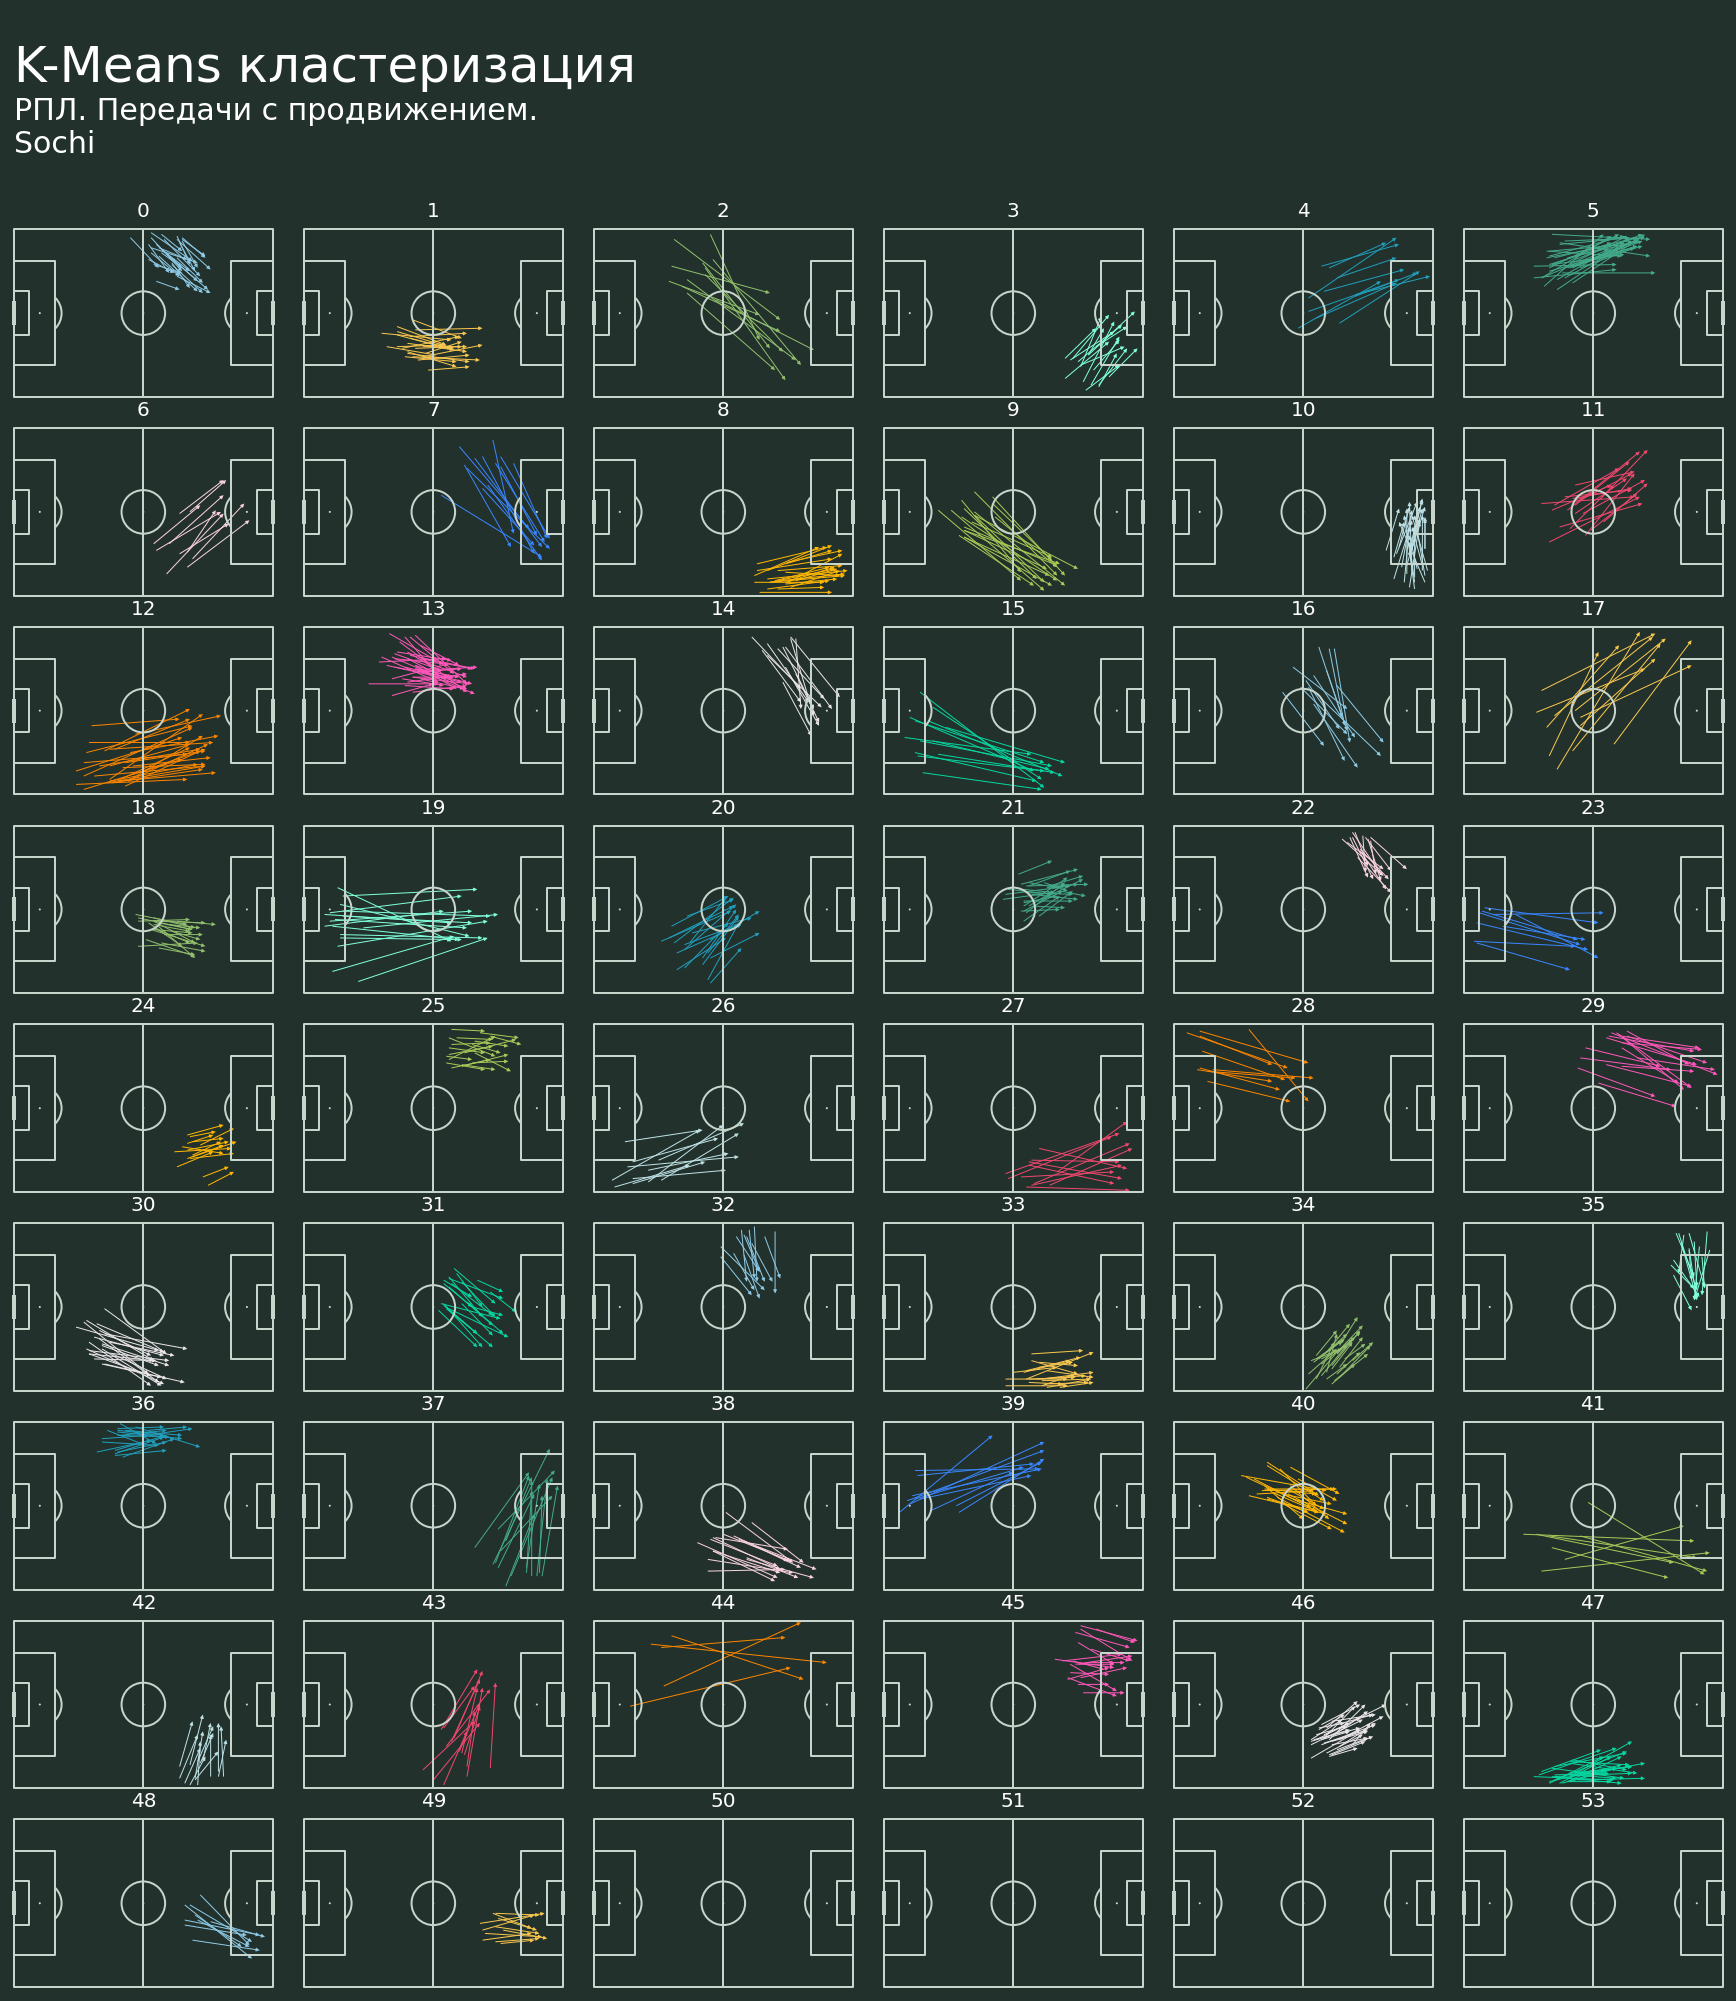

In [11]:
colors = [
    '#8ecae6', '#f9c74f', '#90be6d', '#80ffdb',
    '#219ebc', '#43aa8b', '#fad2e1', '#3a86ff',
    '#ffb703', '#a7c957', '#bee1e6', '#ef476f',
    '#fb8500', '#ff57bb', '#eae4e9', '#06d6a0',
]
    
# Example of the pitch grid is taken from https://mplsoccer.readthedocs.io/en/latest/gallery/pitch_plots/plot_grid.html
pitch = Pitch(
    line_zorder=2, # raise the pitch lines
    pitch_type='wyscout', 
    pitch_color='#22312b', 
    line_color='#c7d5cc'
)

# plot the 8 * 8 grid
fig, axs = pitch.grid(
    nrows=9, ncols=6,
    figheight=30,
    bottom=0.025,  # starts 2.5% in from the figure bottom
    # grid takes up 83% of the figure height
    # I calculated this so most of the figure is pitches
    # 1 - (bottom + endnote_height + endnote_space +
    # title_height + title_space) - 0.025 [space at top]
    grid_height=0.82,
    # reduced the amount of the figure height reserved
    # for the ax_endnote and ax_title since it is in
    # fractions of the figure height and the figure height
    # has increased. e.g. now the title_height is
    # 8% of the figheight (25).
    grid_width=0.95,  # the grid takes up 95% of the figwidth
    # 5% of the grid_height is the space between pitches.
    space=0.08,
    endnote_height=0.0, endnote_space=0.0,
    title_height=0.08, title_space=0.02,
    # Turn off the endnote/title axis. I usually do this after
    # I am happy with the chart layout and text placement
    axis=False
)
fig.set_facecolor('#22312b')

# teams = df_events['team_name'].unique()
team = 'Sochi'
df_passes = progressive_passes_for_team(df_events, team)
df_passes = cluster_passes(df_passes)
popular_clusters = set(df_passes.cluster.value_counts().index.tolist()[0:9])

for idx, ax in enumerate(axs['pitch'].flat):
    color = colors[idx % 16]
    draw_progressive_passes_for_cluster(df_passes, idx, color, popular_clusters, pitch, ax)

# title text
axs['title'].text(0, 0.65, f'K-Means кластеризация', fontsize=50,
                  color='white', va='center', ha='left')
SUB_TEXT = ('РПЛ. Передачи с продвижением.\n'
            f'{team}')
axs['title'].text(0, 0.30, SUB_TEXT, fontsize=30,
                  color='white', va='center', ha='left')


In [12]:
fig.savefig(f'RPL-{team}-50-clusters-progressive-passes.png')

### Распределение пасов по кластерам

Text(0.5, 1.02, 'Распределение пасов по кластерам')

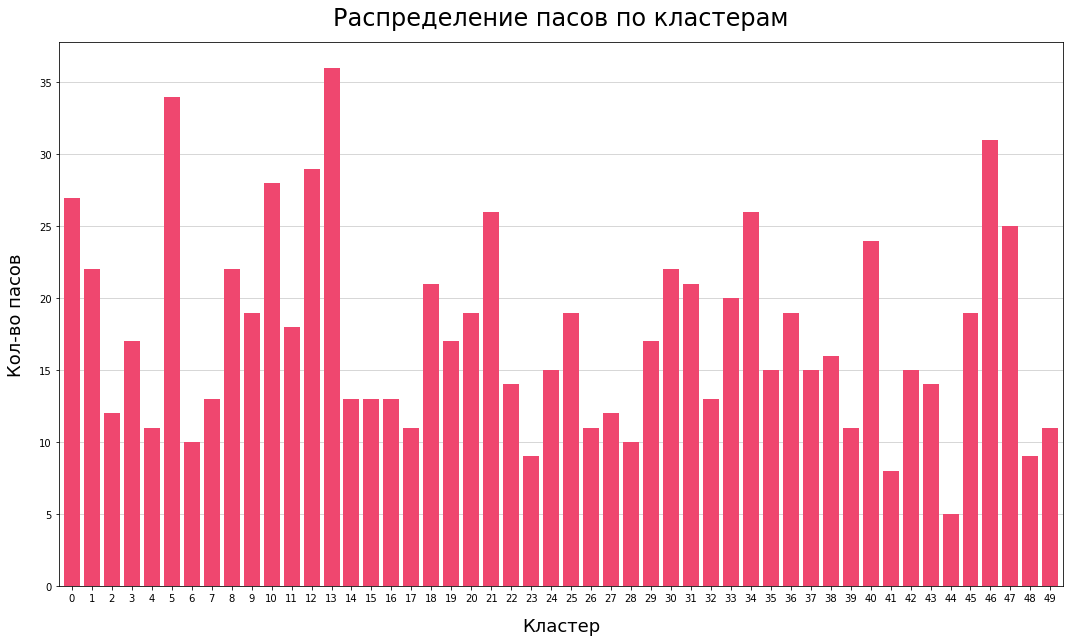

In [16]:
bar_axes = df_passes['cluster'].value_counts().sort_index().plot(
    kind='bar',
    color = ['#ef476f'],
    figsize=(18, 10), 
    rot=0,
    width=.8,
    zorder = 2
)

bar_axes.grid(True, which='major', axis='y', linestyle='-', linewidth=0.5, zorder = 1)
plt.xlabel("Кластер", labelpad=14, fontsize=18)
plt.ylabel("Кол-во пасов", labelpad=14, fontsize=18)

plt.title("Распределение пасов по кластерам", fontsize=24, y=1.02)

In [20]:
# Save to image
fig = bar_axes.get_figure()
fig.savefig(f'RPL-{team}-progressive-passes-clusters-distribution.png')

### Рисуем средние передачи кластеров на одном поле

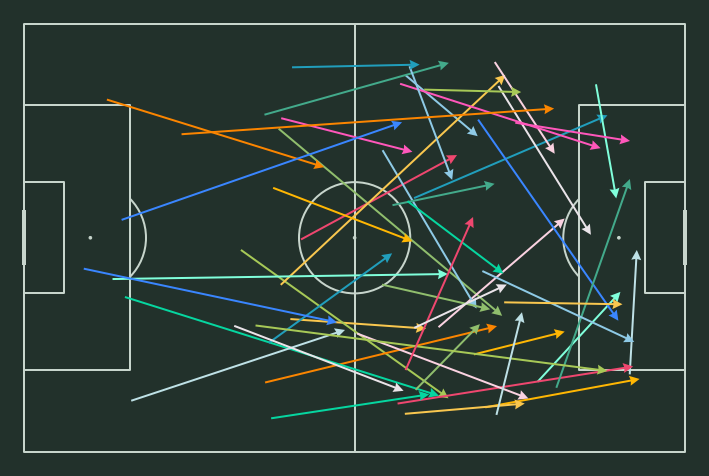

In [15]:
# Example of the pitch grid is taken from https://mplsoccer.readthedocs.io/en/latest/gallery/pitch_plots/plot_grid.html
fig, ax = plt.subplots(figsize=(13, 8.5))
fig.set_facecolor('#22312b')
ax.patch.set_facecolor('#22312b')

pitch = Pitch(
    pitch_type='wyscout', 
    pitch_color='#22312b', 
    line_color='#c7d5cc',
    constrained_layout=False, tight_layout=True
)

pitch.draw(ax=ax)

team = 'Sochi'
df_passes = progressive_passes_for_team(df_events, team)
df_passes = cluster_passes(df_passes)

draw_avg_pass_for_clusters(df_passes, colors, pitch, ax)